In [1]:
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple
import random
from time import perf_counter_ns
import threading # Too lazy to wait for simulation.

def verify_sorted(arr: List[int]) -> bool:
    for i in range(1, len(arr)):
        if arr[i-1] > arr[i]:
            return False 
    return True

RAND_SEED = 69

# Context
> In Mergesort, when the sizes of subarrays are small, the overhead of many recursive calls makes the algorithm inefficient. Therefore, in real use, we often combine Mergesort with Insertion Sort to come up with a hybrid sorting algorithm for better efficiency. The idea is to set a small integer S as a threshold for the size of subarrays. Once the size of a subarray in a recursive call of Mergesort is less than or equal to S, the algorithm will switch to Insertion Sort, which is efficient for small-sized input.

**Notes**
- `S=0` is normal merge sort
- `S -> +Inf` is insertion sort

# (a) Algorithm implementation: Implement the above hybrid algorithm

## Insertion Sort Implementation

In [2]:
def insertion_sort(arr):
    # Duplicate array cus the implementation of merge sort is not inplace.
    # This is to avoid unexpected inplace/non inplace sorting.
    arr = [x for x in arr]
    key_comparisons = 0
    for i in range(1, len(arr)):
        key = arr[i]
        j = i - 1
        while j >= 0:
            key_comparisons += 1
            if key < arr[j]:
                arr[j + 1] = arr[j]
                j -= 1
            else:
                break
        arr[j + 1] = key
    return arr, key_comparisons


## Hybrid Merge Sort
Set `S=0` for normal merge sort

In [3]:
def merge(left: List[int], right: List[int]) -> Tuple[List[int], int]:
    merged = []
    i = j = 0
    comparisons = 0
    
    while i < len(left) and j < len(right):
        comparisons += 1 
        if left[i] <= right[j]:
            merged.append(left[i])
            i += 1
        else:
            merged.append(right[j])
            j += 1
    
    # NOTE: We do not count a key comparison if either the left / right side is empty.
    merged.extend(left[i:])
    merged.extend(right[j:])
    
    return merged, comparisons


# (Sorted, Comparisons)
# S=0 -> Normal merge sort.
def hybrid_merge_sort(arr: List[int], S: int = 0) -> Tuple[List[int], int]:
    if len(arr) <= 1:
        return arr, 0
    if len(arr) <= S:
        return insertion_sort(arr)

    mid = len(arr) // 2
    left_half, left_comparisons = hybrid_merge_sort(arr[:mid], S)
    right_half, right_comparisons = hybrid_merge_sort(arr[mid:], S)
    
    merged, merge_comparisons = merge(left_half, right_half)
    
    return merged, left_comparisons + right_comparisons + merge_comparisons


## Testing implementation for sort.

In [4]:

S_values = [0, 4, 12]
for S in S_values:
    print(f"S = {S}")
    arr = [2, 6, 4, 1, 3, 8, 7, 5]
    sorted_arr, comparisons = hybrid_merge_sort(arr, S)
    print(f"Sorted: {sorted_arr}, Key Comparisons: {comparisons}, Is Sorted: {verify_sorted(sorted_arr)}")

    arr = [1, 2, 3, 4, 5, 6, 7, 8]
    sorted_arr, comparisons = hybrid_merge_sort(arr, S)
    print(f"Sorted: {sorted_arr}, Key Comparisons: {comparisons}, Is Sorted: {verify_sorted(sorted_arr)}")

    arr = [1, 3, 2]
    sorted_arr, comparisons = hybrid_merge_sort(arr)
    print(f"Sorted: {sorted_arr}, Key Comparisons: {comparisons}, Is Sorted: {verify_sorted(sorted_arr)}")

    arr = []
    sorted_arr, comparisons = hybrid_merge_sort(arr)
    print(f"Sorted: {sorted_arr}, Key Comparisons: {comparisons}, Is Sorted: {verify_sorted(sorted_arr)}")



S = 0
Sorted: [1, 2, 3, 4, 5, 6, 7, 8], Key Comparisons: 16, Is Sorted: True
Sorted: [1, 2, 3, 4, 5, 6, 7, 8], Key Comparisons: 12, Is Sorted: True
Sorted: [1, 2, 3], Key Comparisons: 2, Is Sorted: True
Sorted: [], Key Comparisons: 0, Is Sorted: True
S = 4
Sorted: [1, 2, 3, 4, 5, 6, 7, 8], Key Comparisons: 18, Is Sorted: True
Sorted: [1, 2, 3, 4, 5, 6, 7, 8], Key Comparisons: 10, Is Sorted: True
Sorted: [1, 2, 3], Key Comparisons: 2, Is Sorted: True
Sorted: [], Key Comparisons: 0, Is Sorted: True
S = 12
Sorted: [1, 2, 3, 4, 5, 6, 7, 8], Key Comparisons: 16, Is Sorted: True
Sorted: [1, 2, 3, 4, 5, 6, 7, 8], Key Comparisons: 7, Is Sorted: True
Sorted: [1, 2, 3], Key Comparisons: 2, Is Sorted: True
Sorted: [], Key Comparisons: 0, Is Sorted: True


# (b) Generate input data: Generate arrays of increasing sizes, in a range from 1,000 to 10 million. For each of the sizes, generate a random dataset of integers in the range of [1, …, x], where x is the largest number you allow for your datasets.

In [5]:
# size_examples = [(size, examples_per_size)]
def generate_data(size_samples: List[Tuple[int, int]]):
    MAX = 1000000
    datasets = []
    for (size, examples_per_size) in size_samples:
        examples = [[]] * examples_per_size # Create buffer for data creation.

        for i in range(examples_per_size):
            examples[i] = [
                random.randint(1, MAX) for _ in range(size)
            ]
        
        datasets.append({
            "size": size,
            "examples": examples
        })
    return datasets

random.seed(RAND_SEED)
dataset_1 = generate_data([
    (1_000, 100), 
    (5_000, 100), 
    (10_000, 100), 
    (50_000, 100), 
])
dataset_2 = generate_data([
    # Any higher takes too long to run.
    (100_000, 1), 
    (500_000, 1), 
    (1_000_000, 1), 
    (5_000_000, 1), 
    (10_000_000, 1), 
])
dataset_3 = generate_data([
    (x, 1) for x in range(1000, 100_000, 1000)
])

# (c) Analyze time complexity: Run your program of the hybrid algorithm on the datasets generated in Step (b). Record the number of key comparisons performed in each case.

> With the value of S fixed, plot the number of key comparisons over different sizes of the input list n. Compare your empirical results with your theoretical analysis of the time complexity. 
> 
> With the input size n fixed, plot the number of key comparisons over different values of S. Compare your empirical results with your theoretical analysis of the time complexity.

In theory, in the worst case, We expect:
-  `S = 0` to be `O(n log n)`
-  `S -> +inf` to be `O(n^2)`

![Theoretical Analysis](./images/theoretical-analysis.png)

Simplified down to `O(n log (n/s) + Sn)`


In [ ]:
# (S, color)[]
def init_test(s_values: List[Tuple[int, str]]):
    tests = []
    for (s, color) in s_values:
        test = {
            'X': [],
            'comparisons': [],
            'duration': [],
            'S': s,
            'color': color
        }
        tests.append(test)
    return tests

def run_test(test, dataset):
    for d in dataset:
        tally_comparisons = 0
        tally_duration = 0
    
        size = d['size']
        examples = d['examples']

        for i, example in enumerate(examples):
            start_time = perf_counter_ns()
            sorted_arr, comparisons = hybrid_merge_sort(examples[i], test['S'])
            end_time = perf_counter_ns()
            tally_comparisons += comparisons
            tally_duration += end_time - start_time
        
        test['X'].append(size)
        test['comparisons'].append(tally_comparisons / len(examples))
        test['duration'].append(tally_duration / len(examples))

## Fixed S vs n

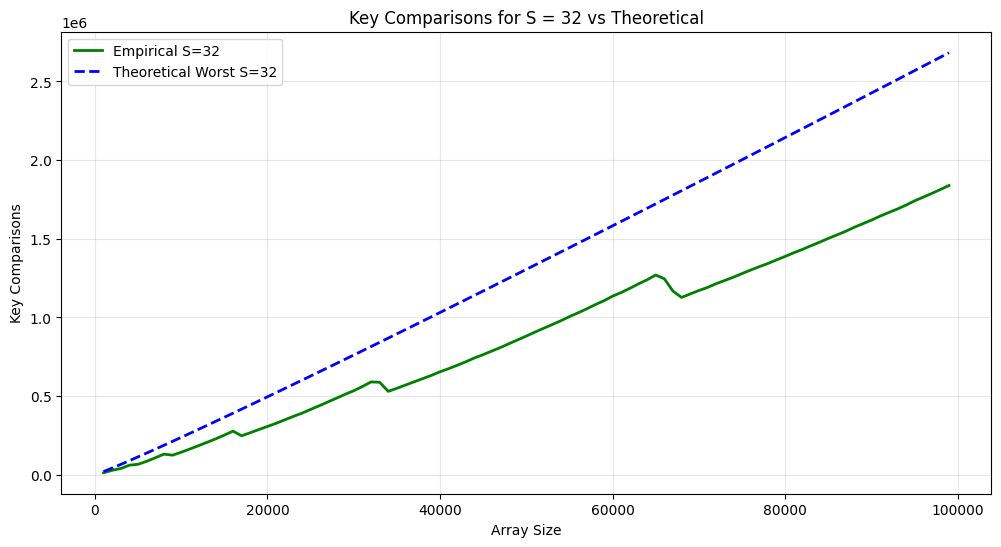

In [ ]:
# We do for S = 0, 4, 8, 16, 32
S_theoretical = ...
test_s0 = init_test([
    (S_theoretical, "green"), 
])

for test in test_s0:
    run_test(test, dataset_3)

def theoretical_comparisons(n, s):
    if s == 0:
        return n * np.log2(n)
    else:
        return n*np.log2(n/s) + (s*n - n)/2

n_values = np.array(test_s0[0]['X'])
theoretical_values = [theoretical_comparisons(n, S_theoretical) for n in n_values]

plt.figure(figsize=(12, 6))
plt.plot(test_s0[0]['X'], test_s0[0]['comparisons'], label=f"Empirical S={test_s0[0]['S']}", color=test_s0[0]['color'], linewidth=2)
plt.plot(n_values, theoretical_values, label=f"Theoretical Worst S={S_theoretical}", color='blue', linewidth=2, linestyle='--')

plt.xlabel('Array Size')
plt.ylabel('Key Comparisons')
plt.title(f'Key Comparisons for S = {S_theoretical} vs Theoretical')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


# Variable S vs Fixed n

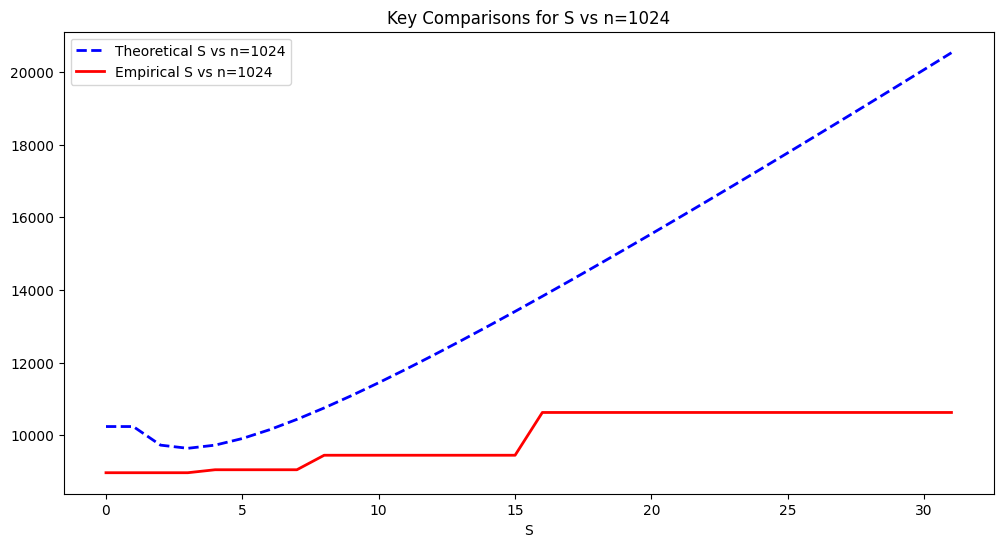

In [ ]:
# We do for n = 1000, 1024, 2048
n = 1024
random.seed(RAND_SEED)
arr = [random.randint(1, 1000000) for _ in range(n)]

X = []
Y = []
theoretical_values = []
for s in range(0, 32, 1):
    sorted_arr, comparisons = hybrid_merge_sort(arr, s)
    X.append(s)
    Y.append(comparisons)
    theoretical_values.append(theoretical_comparisons(n, s))

plt.figure(figsize=(12, 6))
plt.xlabel('S')
# Plot theoretical
plt.plot(X, theoretical_values, label=f"Theoretical S vs n={n}", color='blue', linewidth=2, linestyle='--')
plt.title(f'Key Comparisons for S vs n={n}')
plt.plot(X, Y, label=f"Empirical S vs n={n}", color='red', linewidth=2)

plt.legend()
plt.show()



In [ ]:
tests_1 = init_test([
    (0, "green"), # From here onwards, green will be normal merge sort.
    (4, "orange"),
    (8, "red"),
    (16, "purple"),
    (32, "yellow"),
])

for i, test in enumerate(tests_1):
    run_test(test, dataset_1)

| S | 1000 | 5000 | 10000 | 50000 |
|:---|:---|:---|:---|:---|
| 0 | 8707.98 | 55220.45 | 120452.05 | 718187.94 |
| 4 | 8766.68 | 55256.63 | 120506.52 | 718402.42 |
| 8 | 9122.33 | 55754.95 | 121498.46 | 728966.98 |
| 16 | 10314.56 | 58536.1 | 127082.01 | 769658.47 |
| 32 | 13355.87 | 66762.53 | 143596.67 | 881042.53 |


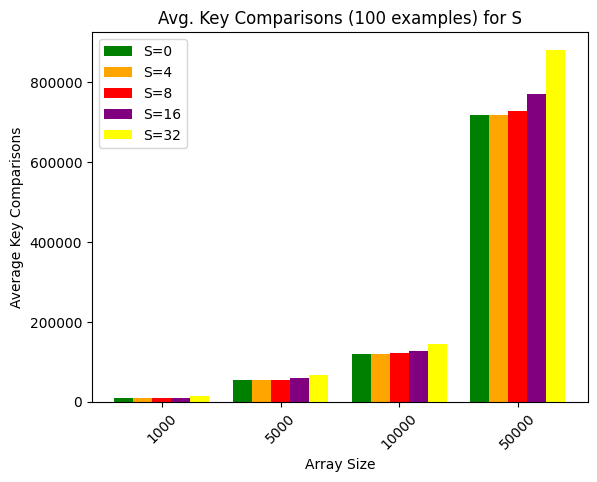

In [7]:
categories = [f"{d["size"]}" for d in dataset_1]

x = np.arange(len(categories))
width = 0.8 / len(tests_1)

print(f"| S | {" | ".join(categories)} |")
print(f"|:---|{':---|' * len(categories)}")
for i, test in enumerate(tests_1):
    offset = (i - (len(tests_1) - 1) / 2) * width
    plt.bar(x + offset, test['comparisons'], width, label=f'S={test["S"]}', color=test['color'])
    comparisons_str = [str(comp) for comp in test['comparisons']]
    print(f"| {test['S']} | {' | '.join(comparisons_str)} |")

plt.xlabel('Array Size')
plt.ylabel('Average Key Comparisons')
plt.title('Avg. Key Comparisons (100 examples) for S')
plt.xticks(x, categories)
plt.xticks(rotation=45)
plt.legend()
plt.show()


| S | 1000 | 5000 | 10000 | 50000 |
|:---|:---|:---|:---|:---|
| 0 | 8707.98 | 55220.45 | 120452.05 | 718187.94 |
| 4 | 8766.68 | 55256.63 | 120506.52 | 718402.42 |
| 8 | 9122.33 | 55754.95 | 121498.46 | 728966.98 |
| 16 | 10314.56 | 58536.1 | 127082.01 | 769658.47 |
| 32 | 13355.87 | 66762.53 | 143596.67 | 881042.53 |

In [8]:
tests_2 = init_test([
    (0, "green"), # From here onwards, green will be normal merge sort.
    (4, "orange"),
    (8, "red"),
    (16, "purple"),
    (32, "yellow"),
])

for i, test in enumerate(tests_2):
    run_test(test, dataset_2)

KeyboardInterrupt: 

| S | 100000 | 500000 | 1000000 | 5000000 | 10000000 |
|:---|:---|:---|:---|:---|:---|
| 0 | 1536495.0 | 8836385.0 | 18674723.0 | 105051834.0 | 220098497.0 |
| 4 | 1537095.0 | 8863758.0 | 18728360.0 | 105111731.0 | 220221098.0 |
| 8 | 1558357.0 | 9037408.0 | 19073861.0 | 105555895.0 | 221107282.0 |
| 16 | 1640075.0 | 9614676.0 | 20225592.0 | 108210097.0 | 226418097.0 |
| 32 | 1862461.0 | 11093973.0 | 23187994.0 | 116159684.0 | 242314167.0 |


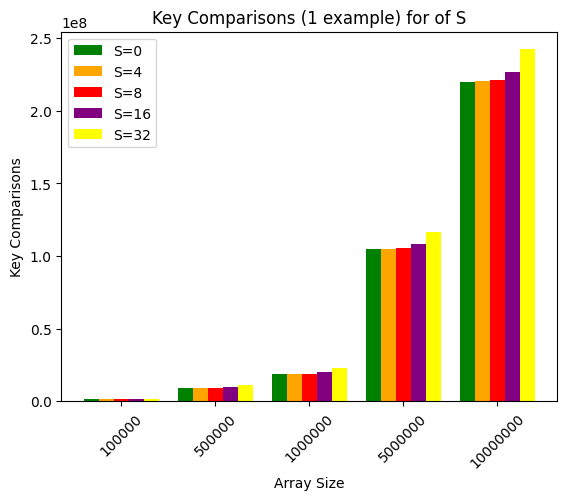

In [ ]:
categories = [f"{d["size"]}" for d in dataset_2]

x = np.arange(len(categories))
width = 0.8 / len(tests_2)

print(f"| S | {" | ".join(categories)} |")
print(f"|:---|{':---|' * len(categories)}")
for i, test in enumerate(tests_2):
    offset = (i - (len(tests_2) - 1) / 2) * width
    plt.bar(x + offset, test['comparisons'], width, label=f'S={test["S"]}', color=test['color'])
    comparisons_str = [str(comp) for comp in test['comparisons']]
    print(f"| {test['S']} | {' | '.join(comparisons_str)} |")

plt.xlabel('Array Size')
plt.ylabel('Key Comparisons')
plt.title('Key Comparisons (1 example) for of S')
plt.xticks(x, categories)
plt.xticks(rotation=45)
plt.legend()
plt.show()

| S | 100000 | 500000 | 1000000 | 5000000 | 10000000 |
|:---|:---|:---|:---|:---|:---|
| 0 | 1536495.0 | 8836385.0 | 18674723.0 | 105051834.0 | 220098497.0 |
| 4 | 1537095.0 | 8863758.0 | 18728360.0 | 105111731.0 | 220221098.0 |
| 8 | 1558357.0 | 9037408.0 | 19073861.0 | 105555895.0 | 221107282.0 |
| 16 | 1640075.0 | 9614676.0 | 20225592.0 | 108210097.0 | 226418097.0 |
| 32 | 1862461.0 | 11093973.0 | 23187994.0 | 116159684.0 | 242314167.0 |

In [ ]:
tests_3 = init_test([
    (0, "green"), # From here onwards, green will be normal merge sort.
    (4, "orange"),
    (8, "red"),
    (16, "purple"),
    (32, "yellow"),
])

for i, test in enumerate(tests_3):
    run_test(test, dataset_3)

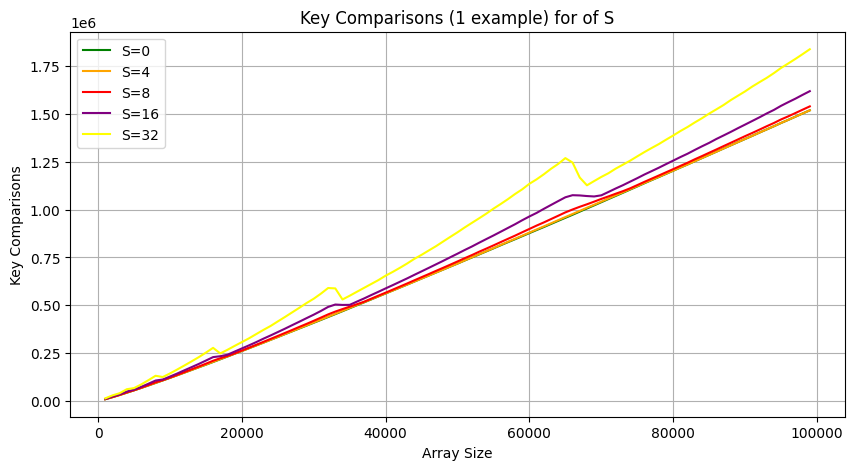

In [ ]:
# Plot the results using line plot
plt.figure(figsize=(10, 5))

for test in tests_3:
    plt.plot(test['X'], test['comparisons'], label=f"S={test['S']}", color=test['color'])

plt.xlabel('Array Size')
plt.ylabel('Key Comparisons')
plt.title('Key Comparisons (1 example) for of S')
plt.grid(True)
plt.legend()
plt.show()

**Compared to the theoretical time analysis, the algorithm trends towards `O(n log (n/s) + Sn)`**

Interestingly, there are visible **spikes**. 

We hypothesize this is due to how **each subarray gets divided** and insertion sort requiring more key comparisons (As we will verify). 

Example with `S=32`: `65,000` breaks down to more *large (N -> 32)* subarrays than `68,000`to do insertion sort. 



> Using different sizes of input datasets, study how to determine an optimal value of S for the best performance of this hybrid algorithm.

Based on the above plots, hybrid merge requires more key comparisons than normal merge sort. 

**As S -> 0**, the algorithm approaches to normal merge sort.

For `0 < S <= 4`, it requires about the same amount of key comparisons.

**As S -> inf**, the algorithm approaches to insertion sort.

We can verify this trend by testing against small array values.

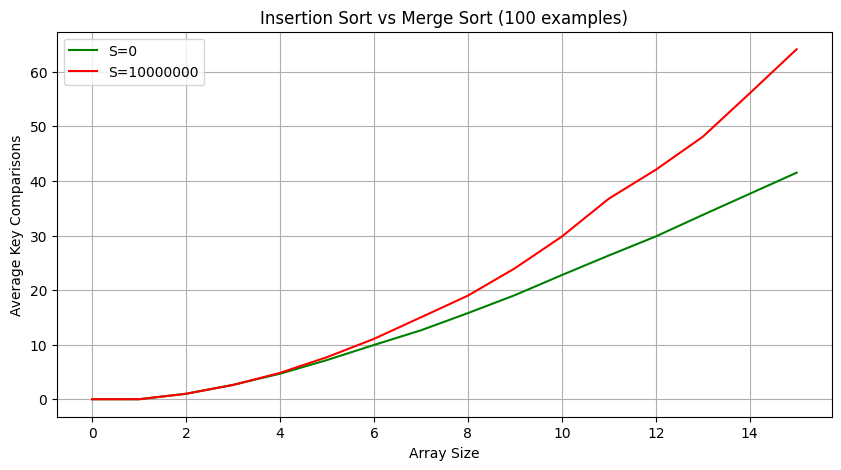

In [ ]:
analysis_dataset_1 = generate_data([
  (x, 100) for x in range(0, 16)
])
analysis_tests_1 = init_test([
    (0, "green"), # S = 0 is normal merge sort.
    (10000000, "red"), # S -> Inf is insertion sort. Its essentially insertion sort lol.
])

for i, test in enumerate(analysis_tests_1):
    run_test(test, analysis_dataset_1)

# Plot the results
plt.figure(figsize=(10, 5))

for test in analysis_tests_1:
    plt.plot(test['X'], test['comparisons'], label=f"S={test['S']}", color=test['color'])

plt.grid(True)
plt.xlabel('Array Size')
plt.ylabel('Average Key Comparisons')
plt.title('Insertion Sort vs Merge Sort (100 examples)')
plt.legend()
plt.show()



If we go by **key comparisons**, we see no significant difference for `S <= 4`, however, insertion sort starts to shoot up when `S > 4` . 

As hinted in the lab,
> In Mergesort, when the sizes of subarrays are small, **the overhead of many recursive calls makes the algorithm inefficient**. Therefore, in real use, we often combine Mergesort with Insertion Sort to come up with a hybrid sorting algorithm for better efficiency. The idea is to set a small integer S as a threshold for the size of subarrays. Once the size of a subarray in a recursive call of Mergesort is less than or equal to S, the algorithm will switch to Insertion Sort, which is efficient for small-sized input.

Generally, CPU time is highly dependent on:
- The implementation.
- The machine it runs on.
- The environment.

Judging by the chart above, perhaps `S=4` is the ideal balance for CPU time and key comparisons.

Let's explore this overhead in terms of CPU time.


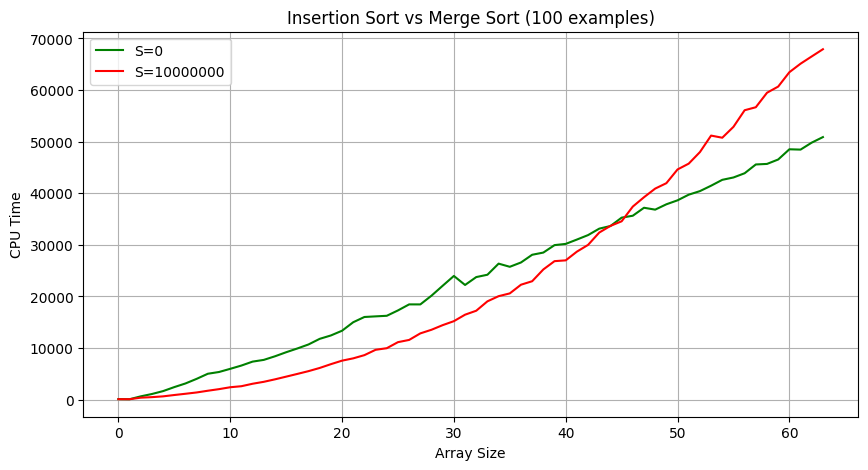

In [ ]:
analysis_dataset_1 = generate_data([
  (x, 100) for x in range(0, 64)
])
analysis_tests_1 = init_test([
    (0, "green"), # S = 0 is normal merge sort.
    (10000000, "red"), # S -> Inf is insertion sort. Its essentially insertion sort lol.
])

for i, test in enumerate(analysis_tests_1):
    run_test(test, analysis_dataset_1)

# Plot the results
plt.figure(figsize=(10, 5))

for test in analysis_tests_1:
    plt.plot(test['X'], test['duration'], label=f"S={test['S']}", color=test['color'])

plt.grid(True)
plt.xlabel('Array Size')
plt.ylabel('CPU Time')
plt.title('Insertion Sort vs Merge Sort (100 examples)')
plt.legend()
plt.show()


Here, insertion sort surpasses merge sort after array size 40.

Let's explore some values from 0 to 40.

In [ ]:
confirmation_tests_1 = init_test([
    (0, "green"), # From here onwards, green will be normal merge sort.
    (4, "orange"),
    (8, "red"),
    (16, "purple"),
    (24, "yellow"),
    (32, "cyan"),
    (40, "magenta"),
    (64, "pink"),
])

for i, test in enumerate(confirmation_tests_1):
    run_test(test, dataset_1)


| S | 1000 | 5000 | 10000 | 50000 |
|:---|:---|:---|:---|:---|
| 0 | 8707.98 | 55220.45 | 120452.05 | 718187.94 |
| 4 | 8766.68 | 55256.63 | 120506.52 | 718402.42 |
| 8 | 9122.33 | 55754.95 | 121498.46 | 728966.98 |
| 16 | 10314.56 | 58536.1 | 127082.01 | 769658.47 |
| 24 | 10314.56 | 66762.53 | 143596.67 | 832357.11 |
| 32 | 13355.87 | 66762.53 | 143596.67 | 881042.53 |
| 40 | 13355.87 | 86805.47 | 183698.78 | 881042.53 |
| 64 | 20296.18 | 86805.47 | 183698.78 | 1141049.75 |


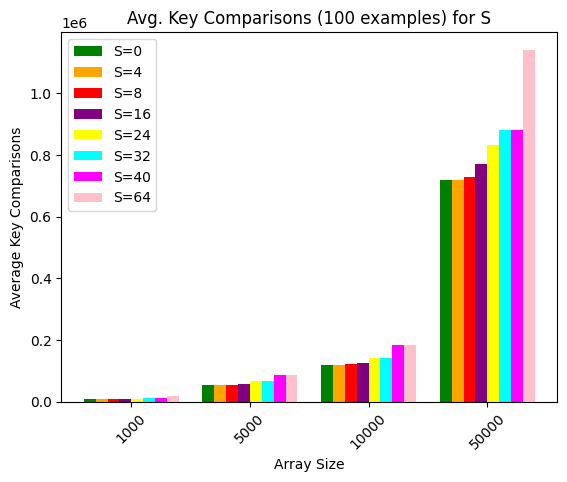

In [ ]:
categories = [f"{d["size"]}" for d in dataset_1]

x = np.arange(len(categories))
width = 0.8 / len(confirmation_tests_1)

print(f"| S | {" | ".join(categories)} |")
print(f"|:---|{':---|' * len(categories)}")
for i, test in enumerate(confirmation_tests_1):
    offset = (i - (len(confirmation_tests_1) - 1) / 2) * width
    plt.bar(x + offset, test['comparisons'], width, label=f'S={test["S"]}', color=test['color'])
    comparisons_str = [str(comp) for comp in test['comparisons']]
    print(f"| {test['S']} | {' | '.join(comparisons_str)} |")

plt.xlabel('Array Size')
plt.ylabel('Average Key Comparisons')
plt.title('Avg. Key Comparisons (100 examples) for S')
plt.xticks(x, categories)
plt.xticks(rotation=45)
plt.legend()
plt.show()

| S | 1000 | 5000 | 10000 | 50000 |
|:---|:---|:---|:---|:---|
| 0 | 8707.98 | 55220.45 | 120452.05 | 718182.0 |
| 4 | 8766.68 | 55256.63 | 120506.52 | 718390.61 |
| 8 | 9122.33 | 55754.95 | 121498.46 | 728991.37 |
| 16 | 10314.56 | 58536.1 | 127082.01 | 769740.26 |
| 40 | 13355.87 | 86805.47 | 183698.78 | 881129.68 |

| S | 1000 | 5000 | 10000 | 50000 |
|:---|:---|:---|:---|:---|
| 0 | 1199748.77 | 7110689.2 | 15577658.41 | 88432729.1 |
| 4 | 924059.17 | 6221370.89 | 13552385.05 | 77549462.91 |
| 8 | 848249.94 | 5668605.86 | 12351420.43 | 72210994.99 |
| 16 | 861100.85 | 5359079.15 | 11739480.44 | 70173870.49 |
| 24 | 845454.16 | 5575839.65 | 12132420.92 | 72542500.43 |
| 32 | 992510.05 | 5558434.22 | 12191164.57 | 74097125.36 |
| 40 | 990989.53 | 6672096.65 | 14371062.08 | 76561389.58 |
| 64 | 1528360.82 | 7025947.94 | 14869874.96 | 93065477.54 |


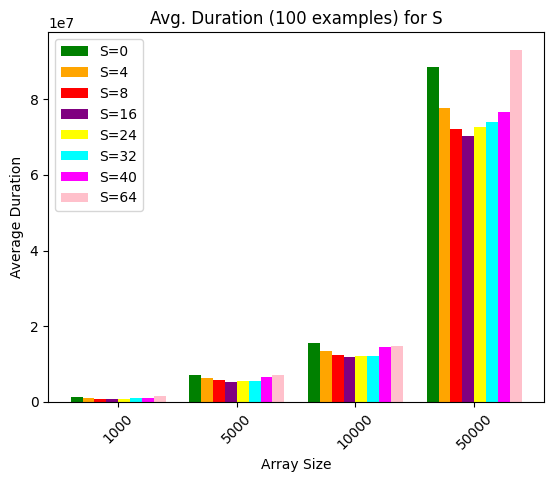

In [ ]:
categories = [f"{d["size"]}" for d in dataset_1]

x = np.arange(len(categories))
width = 0.8 / len(confirmation_tests_1)

print(f"| S | {" | ".join(categories)} |")
print(f"|:---|{':---|' * len(categories)}")
for i, test in enumerate(confirmation_tests_1):
    offset = (i - (len(confirmation_tests_1) - 1) / 2) * width
    plt.bar(x + offset, test['duration'], width, label=f'S={test["S"]}', color=test['color'])
    comparisons_str = [str(comp) for comp in test['duration']]
    print(f"| {test['S']} | {' | '.join(comparisons_str)} |")

plt.xlabel('Array Size')
plt.ylabel('Average Duration')
plt.title('Avg. Duration (100 examples) for S')
plt.xticks(x, categories)
plt.xticks(rotation=45)
plt.legend()
plt.show()

Interestingly, `S=16` performs the best for `dataset_1`.

| S | 1000 | 5000 | 10000 | 50000 |
|:---|:---|:---|:---|:---|
| 0 | 1221030.87 | 7512705.09 | 15565893.32 | 89836786.7 |
| 4 | 928682.07 | 6370284.64 | 13690354.63 | 78895033.76 |
| 8 | 852423.81 | 5717107.98 | 12592711.67 | 73646031.61 |
| 16 | 884497.88 | 5473283.4 | 11885122.46 | 71028331.67 |
| 24 | 862910.79 | 5603934.96 | 12239355.44 | 73036241.26 |
| 32 | 1005687.15 | 5623966.19 | 12305539.55 | 75343337.09 |
| 40 | 999288.36 | 6730803.39 | 14510395.46 | 76313766.29 |
| 64 | 1458412.9 | 6719647.5 | 14519962.1 | 93407687.05 |

**But is `S=16` the best? Perhaps it could be some other value in the range, `(8, 24)`?**

Lets test some nearby values `[14, 18]` to scope our search.

In [ ]:
locality_tests = init_test([
    (14, "green"),
    (15, "red"),
    (16, "purple"),
    (17, "blue"),
    (18, "yellow"),
])

for i, test in enumerate(locality_tests):
    run_test(test, dataset_1)

| S | 1000 | 5000 | 10000 | 50000 |
|:---|:---|:---|:---|:---|
| 14 | 882595.07 | 5633744.63 | 12199188.74 | 74704214.56 |
| 15 | 1108300.41 | 5608898.81 | 12433843.74 | 74543457.9 |
| 16 | 878921.26 | 5663185.41 | 12128421.26 | 72633970.08 |
| 17 | 863291.69 | 5460273.78 | 12032512.55 | 71963528.75 |
| 18 | 862823.39 | 5407238.39 | 11883393.39 | 71847613.76 |


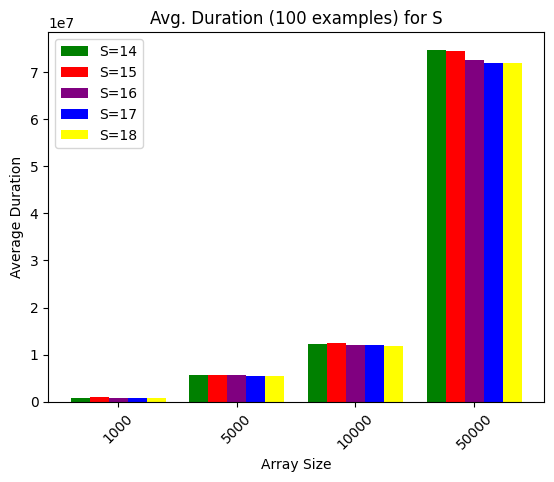

In [ ]:
categories = [f"{d["size"]}" for d in dataset_1]

x = np.arange(len(categories))
width = 0.8 / len(locality_tests)

print(f"| S | {" | ".join(categories)} |")
print(f"|:---|{':---|' * len(categories)}")
for i, test in enumerate(locality_tests):
    offset = (i - (len(locality_tests) - 1) / 2) * width
    plt.bar(x + offset, test['duration'], width, label=f'S={test["S"]}', color=test['color'])
    comparisons_str = [str(comp) for comp in test['duration']]
    print(f"| {test['S']} | {' | '.join(comparisons_str)} |")

plt.xlabel('Array Size')
plt.ylabel('Average Duration')
plt.title('Avg. Duration (100 examples) for S')
plt.xticks(x, categories)
plt.xticks(rotation=45)
plt.legend()
plt.show()

At least for the smaller dataset, the results are highly variable. Unlike the previous test we did, there is no apparent trend to hint to us what `S` should be. 

Perhaps it might be due to the **spikes** as mentioned previously.

For simplicity, let's use `S=16` as our optimal `S` value.

# (d) Compare with original Mergesort: Implement the original version of Mergesort (as learnt in lecture). Compare its performance against the above hybrid algorithm in terms of the number of key comparisons and CPU times on the dataset with 10 million integers. You can use the optimal value of S obtained in (c) for this task.

Using:
- `S=0` Normal Merge Sort
- `S=4` Highest Balance between Key Comparisons and CPU Time
- `S=16` Optimal based on CPU Time


In [ ]:
confirmation_tests_2 = init_test([
    (0, "green"), # From here onwards, green will be normal merge sort.
    (4, "orange"),
    (16, "purple"),
])

for i, test in enumerate(confirmation_tests_2):
    # Use back dataset 2
    run_test(test, dataset_2)

| S | 100000 | 500000 | 1000000 | 5000000 | 10000000 |
|:---|:---|:---|:---|:---|:---|
| 0 | 1536495.0 | 8836385.0 | 18674723.0 | 105051834.0 | 220098497.0 |
| 4 | 1537095.0 | 8863758.0 | 18728360.0 | 105111731.0 | 220221098.0 |
| 16 | 1640075.0 | 9614676.0 | 20225592.0 | 108210097.0 | 226418097.0 |


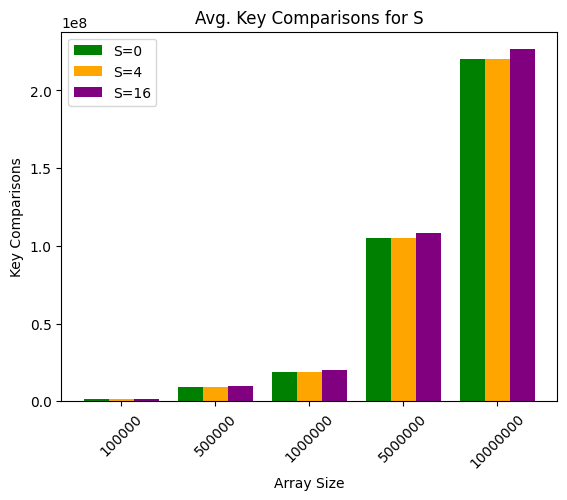

In [ ]:
categories = [f"{d["size"]}" for d in dataset_2]

x = np.arange(len(categories))
width = 0.8 / len(confirmation_tests_2)

print(f"| S | {" | ".join(categories)} |")
print(f"|:---|{':---|' * len(categories)}")
for i, test in enumerate(confirmation_tests_2):
    offset = (i - (len(confirmation_tests_2) - 1) / 2) * width
    plt.bar(x + offset, test['comparisons'], width, label=f'S={test["S"]}', color=test['color'])
    comparisons_str = [str(comp) for comp in test['comparisons']]
    print(f"| {test['S']} | {' | '.join(comparisons_str)} |")

plt.xlabel('Array Size')
plt.ylabel('Key Comparisons')
plt.title('Avg. Key Comparisons for S')
plt.xticks(x, categories)
plt.xticks(rotation=45)
plt.legend()
plt.show()

| S | 100000 | 500000 | 1000000 | 5000000 | 10000000 |
|:---|:---|:---|:---|:---|:---|
| 0 | 1536495.0 | 8836385.0 | 18674723.0 | 105051834.0 | 220098497.0 |
| 4 | 1537095.0 | 8863758.0 | 18728360.0 | 105111731.0 | 220221098.0 |
| 16 | 1640075.0 | 9614676.0 | 20225592.0 | 108210097.0 | 226418097.0 |

| S | 100000 | 500000 | 1000000 | 5000000 | 10000000 |
|:---|:---|:---|:---|:---|:---|
| 0 | 193918000.0 | 1084127583.0 | 2295654584.0 | 13560025000.0 | 28072242000.0 |
| 4 | 168549334.0 | 943511334.0 | 2005515500.0 | 12469607250.0 | 26667374500.0 |
| 16 | 159761041.0 | 923314625.0 | 1969780417.0 | 11778750458.0 | 24361947083.0 |


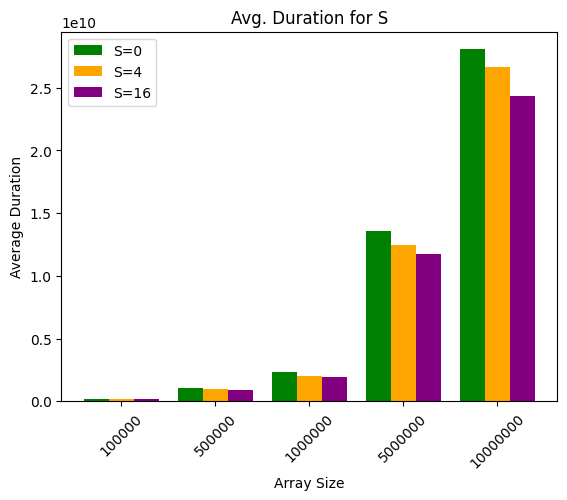

In [ ]:
categories = [f"{d["size"]}" for d in dataset_2]

x = np.arange(len(categories))
width = 0.8 / len(confirmation_tests_2)

print(f"| S | {" | ".join(categories)} |")
print(f"|:---|{':---|' * len(categories)}")
for i, test in enumerate(confirmation_tests_2):
    offset = (i - (len(confirmation_tests_2) - 1) / 2) * width
    plt.bar(x + offset, test['duration'], width, label=f'S={test["S"]}', color=test['color'])
    comparisons_str = [str(comp) for comp in test['duration']]
    print(f"| {test['S']} | {' | '.join(comparisons_str)} |")

plt.xlabel('Array Size')
plt.ylabel('Average Duration')
plt.title('Avg. Duration for S')
plt.xticks(x, categories)
plt.xticks(rotation=45)
plt.legend()
plt.show()

| S | 100000 | 500000 | 1000000 | 5000000 | 10000000 |
|:---|:---|:---|:---|:---|:---|
| 0 | 193918000.0 | 1084127583.0 | 2295654584.0 | 13560025000.0 | 28072242000.0 |
| 4 | 168549334.0 | 943511334.0 | 2005515500.0 | 12469607250.0 | 26667374500.0 |
| 16 | 159761041.0 | 923314625.0 | 1969780417.0 | 11778750458.0 | 24361947083.0 |

In [ ]:
confirmation_tests_3 = init_test([
    (0, "green"), # From here onwards, green will be normal merge sort.
    (4, "orange"),
    (16, "purple"),
])

for i, test in enumerate(confirmation_tests_3):
    run_test(test, dataset_3)

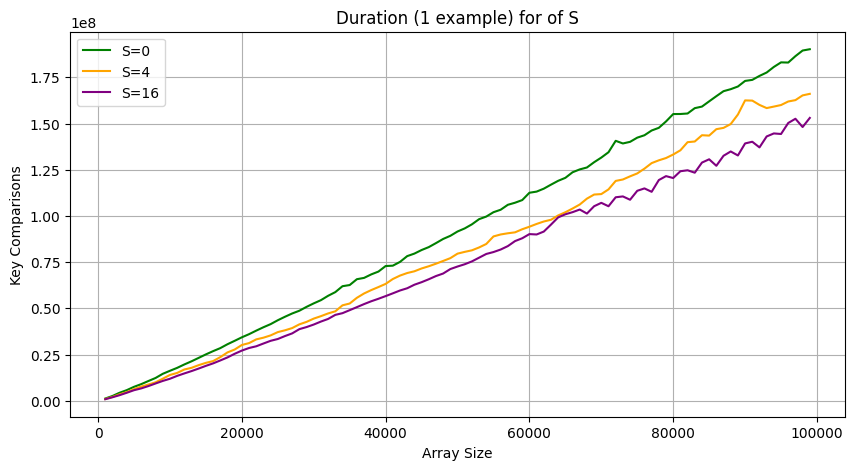

In [ ]:
# Plot the results using line plot
plt.figure(figsize=(10, 5))

for test in confirmation_tests_3:
    plt.plot(test['X'], test['duration'], label=f"S={test['S']}", color=test['color'])

plt.xlabel('Array Size')
plt.ylabel('Key Comparisons')
plt.title('Duration (1 example) for of S')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Test S = 0 against dataset_3 and plot results
test_s0 = init_test([
    (0, "green"),  # S = 0 (normal merge sort)
])

# Run the test
for test in test_s0:
    run_test(test, dataset_3)

# Define the theoretical formula
def theoretical_comparisons(n, s):
    """
    Theoretical formula: -n/s - 1 + n*log(n/s) - n + (s*n - n)/2
    """
    if s == 0:
        # For S = 0, use n*log(n) approximation
        return n * np.log2(n)
    else:
        return -n/s - 1 + n*np.log2(n/s) - n + (s*n - n)/2

# Variable S for theoretical curve (you can change this)
S_theoretical = 0

# Generate theoretical data points
n_values = np.array(test_s0[0]['X'])
theoretical_values = [theoretical_comparisons(n, S_theoretical) for n in n_values]

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_s0[0]['X'], test_s0[0]['comparisons'], label=f"Empirical S={test_s0[0]['S']}", color=test_s0[0]['color'], linewidth=2)
plt.plot(n_values, theoretical_values, label=f"Theoretical S={S_theoretical}", color='blue', linewidth=2, linestyle='--')

plt.xlabel('Array Size')
plt.ylabel('Key Comparisons')
plt.title('Key Comparisons for S = 0 (Normal Merge Sort) vs Theoretical')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Print some statistics
print(f"Dataset 3 size range: {min(test_s0[0]['X'])} to {max(test_s0[0]['X'])}")
print(f"Empirical comparisons range: {min(test_s0[0]['comparisons']):.0f} to {max(test_s0[0]['comparisons']):.0f}")
print(f"Theoretical comparisons range: {min(theoretical_values):.0f} to {max(theoretical_values):.0f}")
print(f"Number of data points: {len(test_s0[0]['X'])}")
print(f"\nTo change the theoretical S value, modify S_theoretical = {S_theoretical} in the code above")
